## Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import mean

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold


from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

## Loading dataset

In [ ]:
# Load the dataset
df = pd.read_csv("US Airline Flight Routes and Fares 1993-2024.csv")

<ipython-input-2-4eacbc52b291>:2: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("US Airline Flight Routes and Fares 1993-2024.csv")


In [ ]:
# Display the first few rows to understand data structure
print(df.head())

       tbl  Year  quarter  citymarketid_1  citymarketid_2  \
0  Table1a  2021        3           30135           33195   
1  Table1a  2021        3           30135           33195   
2  Table1a  2021        3           30140           30194   
3  Table1a  2021        3           30140           30194   
4  Table1a  2021        3           30140           30466   

                            city1                          city2  airportid_1  \
0  Allentown/Bethlehem/Easton, PA  Tampa, FL (Metropolitan Area)        10135   
1  Allentown/Bethlehem/Easton, PA  Tampa, FL (Metropolitan Area)        10135   
2                 Albuquerque, NM          Dallas/Fort Worth, TX        10140   
3                 Albuquerque, NM          Dallas/Fort Worth, TX        10140   
4                 Albuquerque, NM                    Phoenix, AZ        10140   

   airportid_2 airport_1  ...    fare  carrier_lg  large_ms  fare_lg  \
0        14112       ABE  ...   81.43          G4    1.0000    81.43   
1 

In [ ]:
df = df.drop(['tbl', 'tbl1apk' ], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245955 entries, 0 to 245954
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Year            245955 non-null  int64  
 1   quarter         245955 non-null  int64  
 2   citymarketid_1  245955 non-null  int64  
 3   citymarketid_2  245955 non-null  int64  
 4   city1           245955 non-null  object 
 5   city2           245955 non-null  object 
 6   airportid_1     245955 non-null  int64  
 7   airportid_2     245955 non-null  int64  
 8   airport_1       245955 non-null  object 
 9   airport_2       245955 non-null  object 
 10  nsmiles         245955 non-null  int64  
 11  passengers      245955 non-null  int64  
 12  fare            245955 non-null  float64
 13  carrier_lg      244415 non-null  object 
 14  large_ms        244415 non-null  float64
 15  fare_lg         244415 non-null  float64
 16  carrier_low     244343 non-null  object 
 17  lf_ms     

## Handling missing values

In [ ]:
missing_values_summary = df.isnull().sum()
missing_values_summary

,0
Year,0
quarter,0
citymarketid_1,0
citymarketid_2,0
city1,0
city2,0
airportid_1,0
airportid_2,0
airport_1,0
airport_2,0


In [ ]:
df.loc[:, 'fare_lg'] = df.groupby(['city1', 'city2'])['fare_lg'].transform(lambda x: x.fillna(x.mean()))
df.loc[:, 'fare_low'] = df.groupby(['city1', 'city2'])['fare_low'].transform(lambda x: x.fillna(x.mean()))
df.loc[:, 'large_ms'] = df.groupby(['city1', 'city2'])['large_ms'].transform(lambda x: x.fillna(x.mean()))
df.loc[:, 'lf_ms'] = df.groupby(['city1', 'city2'])['lf_ms'].transform(lambda x: x.fillna(x.mean()))

df.loc[:, 'carrier_lg'] = df.groupby(['city1', 'city2'])['carrier_lg'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else None))
df.loc[:, 'carrier_low'] = df.groupby(['city1', 'city2'])['carrier_low'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else None))

df.loc[:, 'Geocoded_City1'] = df['Geocoded_City1'].fillna(df['city1'])
df.loc[:, 'Geocoded_City2'] = df['Geocoded_City2'].fillna(df['city2'])

In [ ]:
missing_values_summary = df.isnull().sum()
missing_values_summary

,0
Year,0
quarter,0
citymarketid_1,0
citymarketid_2,0
city1,0
city2,0
airportid_1,0
airportid_2,0
airport_1,0
airport_2,0


## Outlier detection and removal

In [ ]:
# Check for numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
print("Numeric columns in the dataset:", numeric_columns)

Numeric columns in the dataset: Index(['Year', 'quarter', 'citymarketid_1', 'citymarketid_2', 'airportid_1',
       'airportid_2', 'nsmiles', 'passengers', 'fare', 'large_ms', 'fare_lg',
       'lf_ms', 'fare_low'],
      dtype='object')


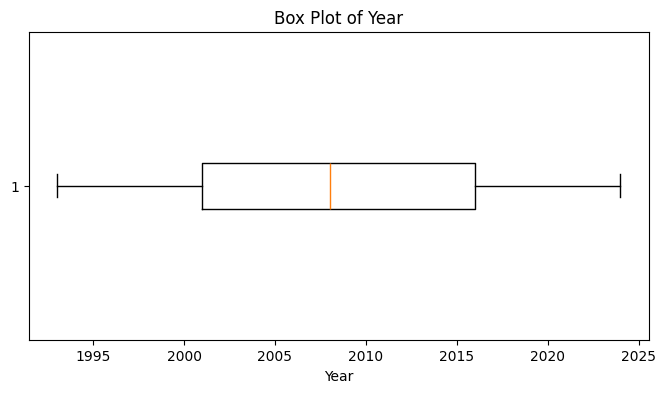

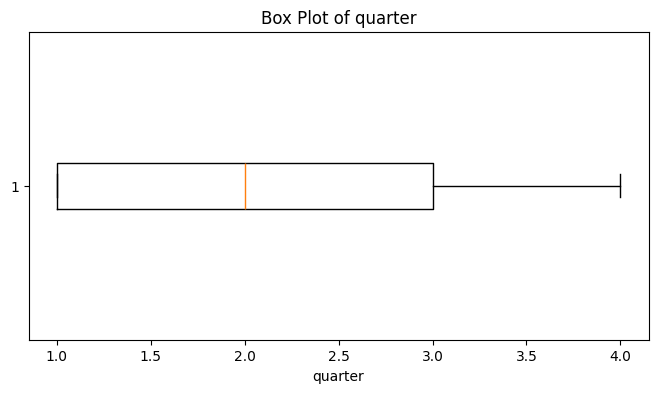

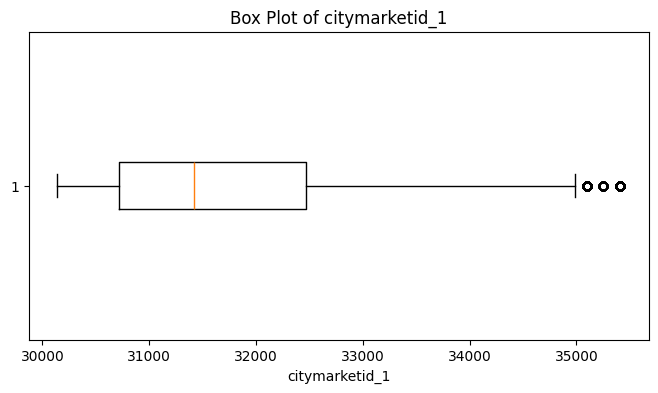

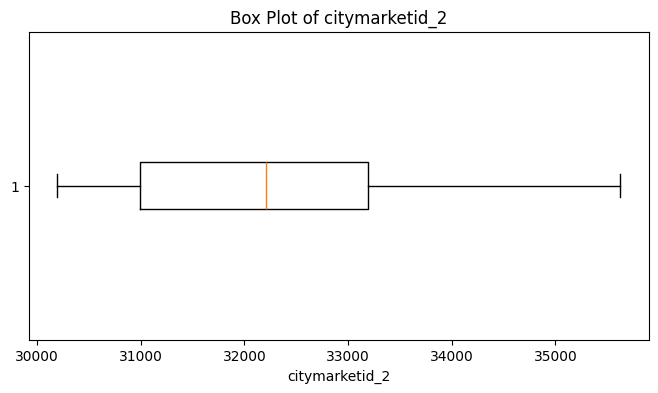

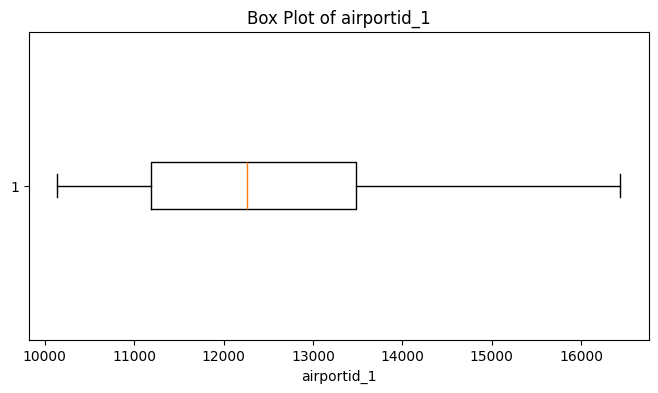

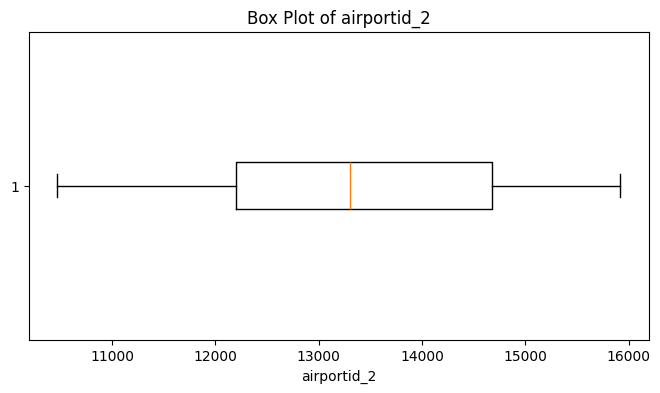

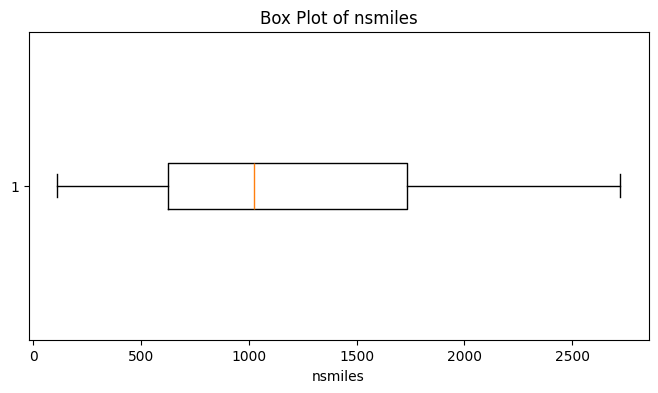

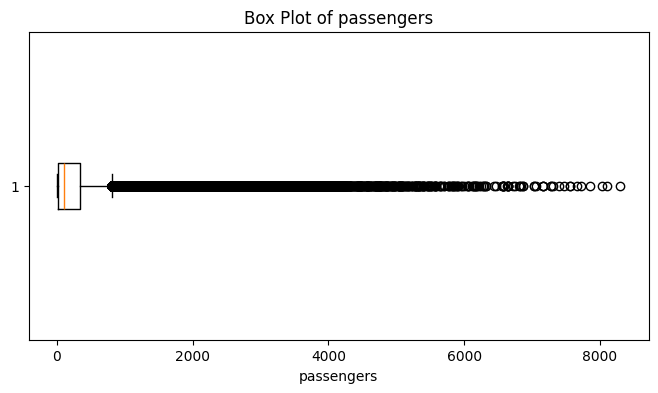

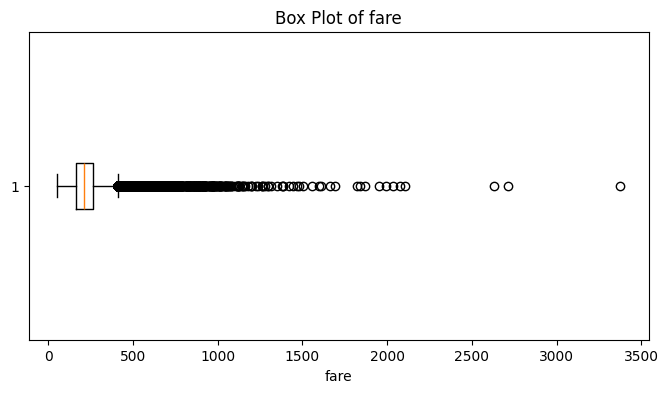

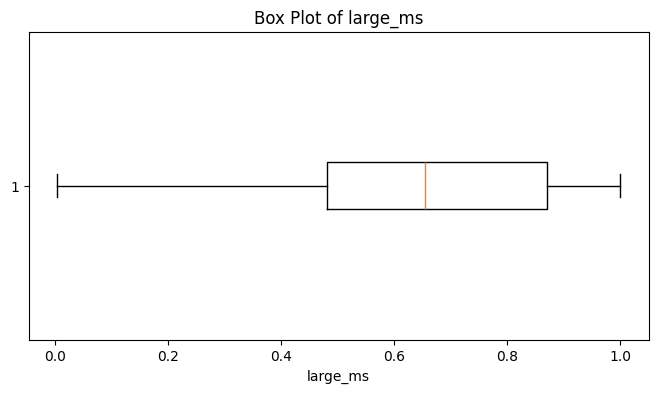

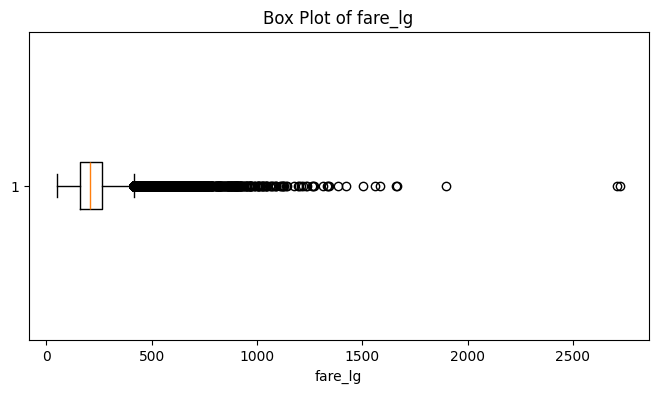

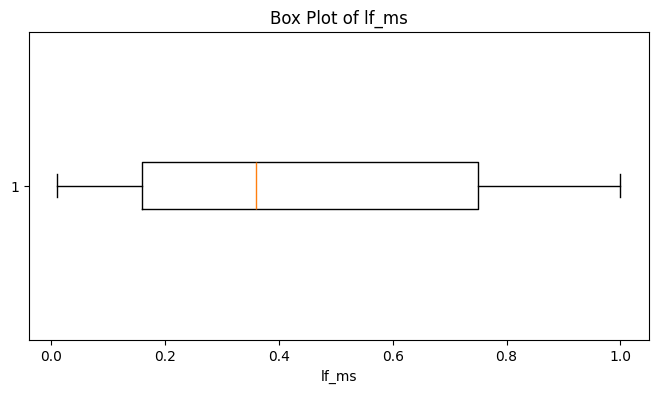

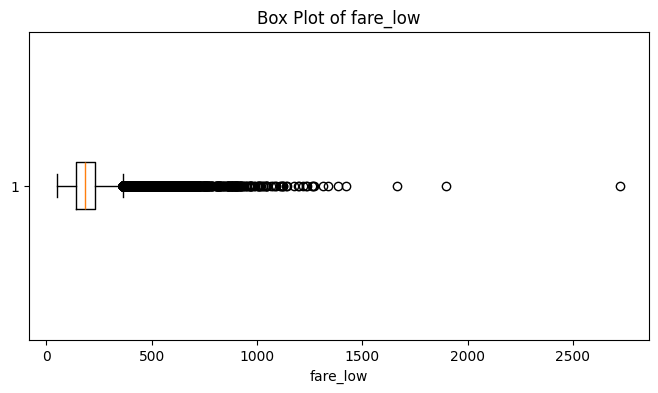

In [ ]:
# Box Plot for each numeric column to visualize outliers
for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    plt.boxplot(df[column].dropna(), vert=False)
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.show()

In [ ]:
# Outlier removal using IQR method for each numeric column
for column in numeric_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [ ]:
# Checking dataset after removing outliers
print("Data after outlier removal:", df.describe())

Data after outlier removal:                 Year        quarter  citymarketid_1  citymarketid_2  \
count  211862.000000  211862.000000   211862.000000   211862.000000   
mean     2008.333061       2.480336    31534.796221    32207.523506   
std         8.702821       1.123020     1056.391820     1249.633558   
min      1993.000000       1.000000    30135.000000    30189.000000   
25%      2001.000000       1.000000    30721.000000    31066.000000   
50%      2008.000000       2.000000    31295.000000    32337.000000   
75%      2016.000000       3.000000    32467.000000    33195.000000   
max      2024.000000       4.000000    34986.000000    35628.000000   

         airportid_1    airportid_2        nsmiles     passengers  \
count  211862.000000  211862.000000  211862.000000  211862.000000   
mean    12410.184781   13247.578041    1180.323404     168.070064   
std      1414.085443    1431.958474     694.709665     193.249112   
min     10135.000000   10466.000000     109.000000      

In [ ]:
# Save the cleaned dataset
df.to_csv('cleaned_airline_data.csv', index=False)

## Label encoding

In [ ]:
columns_to_encode = df.select_dtypes(include=['object']).columns.to_list()
columns_to_encode

['city1',
 'city2',
 'airport_1',
 'airport_2',
 'carrier_lg',
 'carrier_low',
 'Geocoded_City1',
 'Geocoded_City2']

In [ ]:
le = LabelEncoder()

# Apply label encoding using a loop
for column in columns_to_encode:
    df[column] = le.fit_transform(df[column])

df.head()

,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,airport_2,...,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2
0,2021,3,30135,33195,2,115,10135,14112,0,119,...,180,81.43,16,1.0000,81.43,19,1.0000,81.43,110,292
1,2021,3,30135,33195,2,115,10135,15304,0,161,...,19,208.93,11,0.4659,219.98,54,0.1193,154.11,110,292
2,2021,3,30140,30194,1,11,10140,11259,1,20,...,204,184.56,57,0.9968,184.44,60,0.9968,184.44,108,112
3,2021,3,30140,30194,1,11,10140,11298,1,25,...,264,182.64,4,0.9774,183.09,5,0.9774,183.09,108,112
4,2021,3,30140,30466,1,77,10140,14107,1,117,...,398,177.11,57,0.6061,184.49,5,0.3939,165.77,108,227


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211862 entries, 0 to 245938
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Year            211862 non-null  int64  
 1   quarter         211862 non-null  int64  
 2   citymarketid_1  211862 non-null  int64  
 3   citymarketid_2  211862 non-null  int64  
 4   city1           211862 non-null  int64  
 5   city2           211862 non-null  int64  
 6   airportid_1     211862 non-null  int64  
 7   airportid_2     211862 non-null  int64  
 8   airport_1       211862 non-null  int64  
 9   airport_2       211862 non-null  int64  
 10  nsmiles         211862 non-null  int64  
 11  passengers      211862 non-null  int64  
 12  fare            211862 non-null  float64
 13  carrier_lg      211862 non-null  int64  
 14  large_ms        211862 non-null  float64
 15  fare_lg         211862 non-null  float64
 16  carrier_low     211862 non-null  int64  
 17  lf_ms          

## EDA

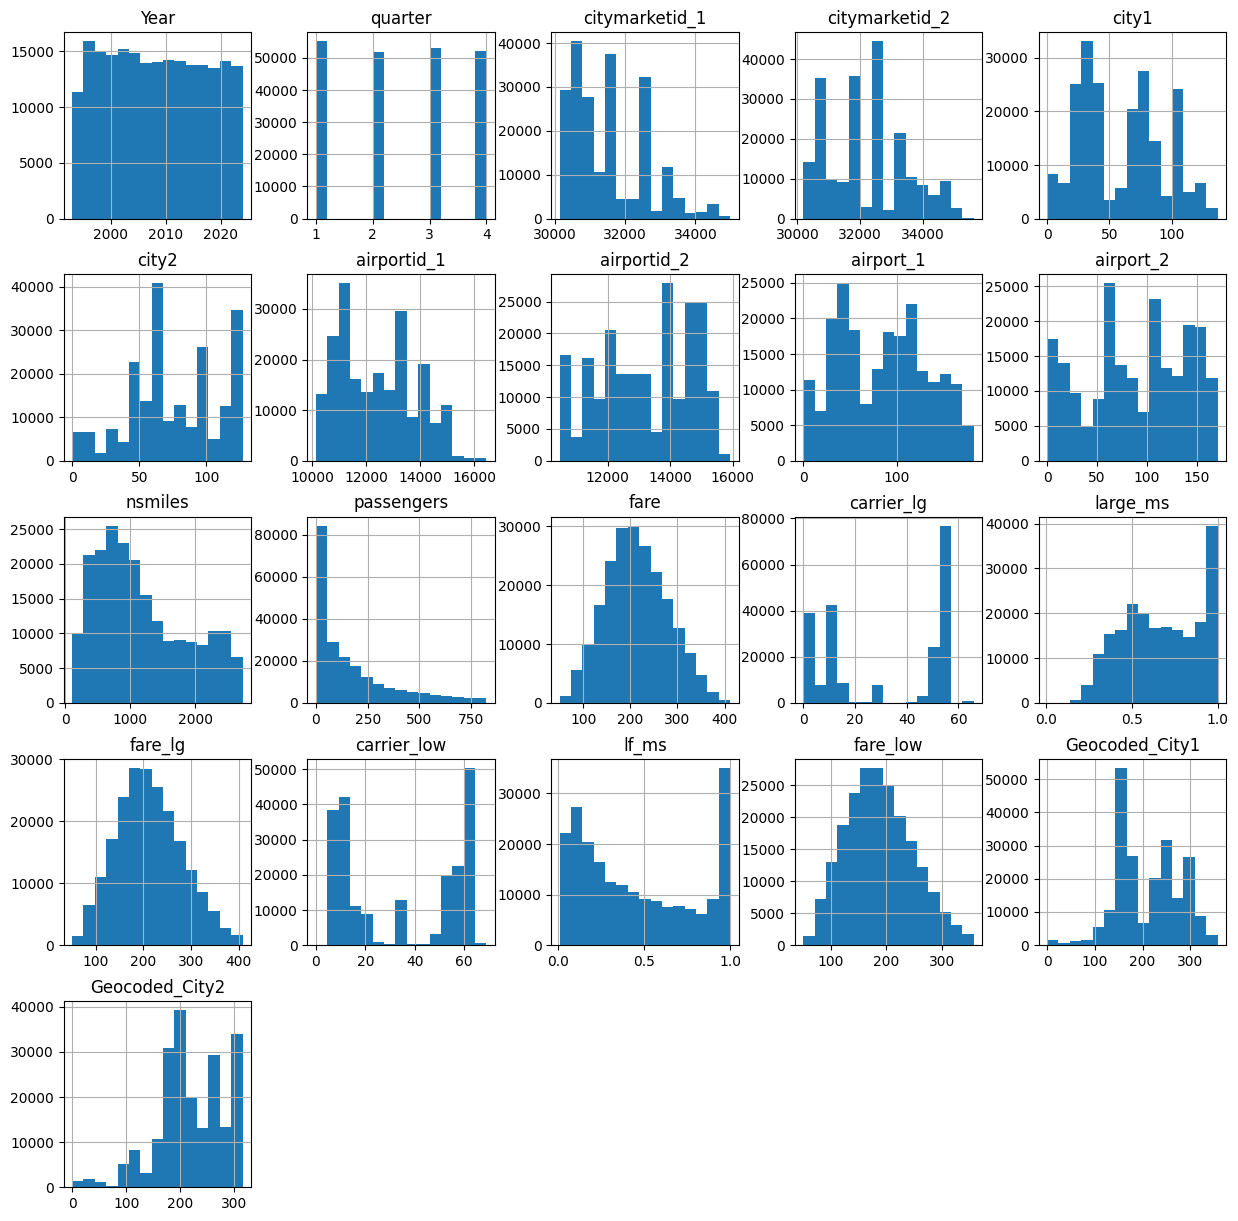

In [ ]:
# Check the distribution of all the features
df.hist(figsize=(15,15),bins = 15)
plt.title("Features Distribution")
plt.show()

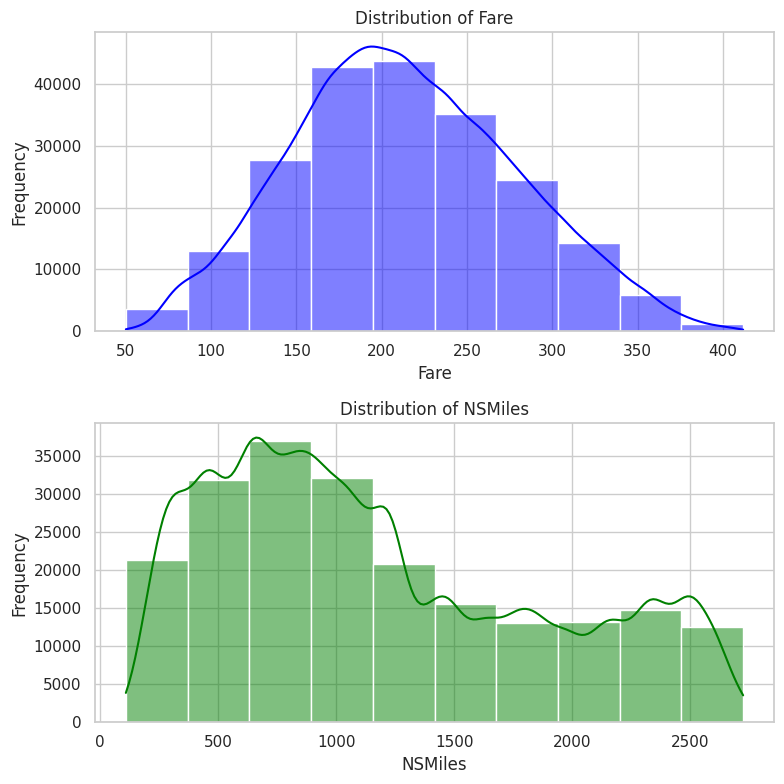

In [ ]:
# Set the style of seaborn
import seaborn as sns
sns.set(style="whitegrid")

# Create subplots for both fare and nsmiles
fig, axes = plt.subplots(2, 1, figsize=(8, 8))  # Adjusted to 2 rows, 1 column

# Histogram for fare
sns.histplot(df['fare'], bins=10, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribution of Fare')
axes[0].set_xlabel('Fare')
axes[0].set_ylabel('Frequency')

# Histogram for nsmiles
sns.histplot(df['nsmiles'], bins=10, kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribution of NSMiles')
axes[1].set_xlabel('NSMiles')
axes[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

<ipython-input-18-c625e3a373ca>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Year', y='Average Fare', data=average_fare_by_year, palette='viridis')


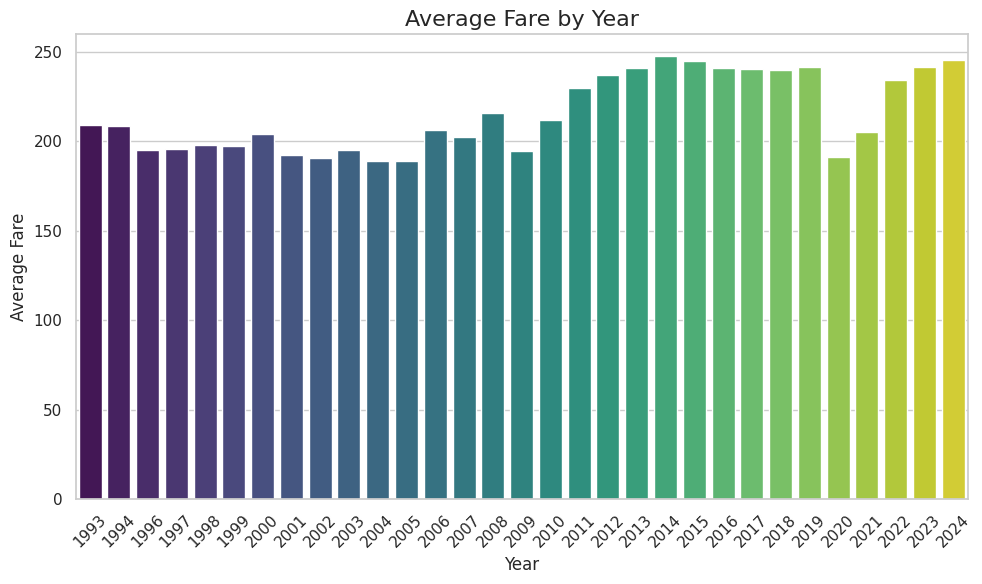

In [ ]:
# Plotting
average_fare_by_year = df.groupby('Year')['fare'].mean().reset_index()
average_fare_by_year.columns = ['Year', 'Average Fare']

plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='Average Fare', data=average_fare_by_year, palette='viridis')
plt.title('Average Fare by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Fare', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-19-72b2efd473b3>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='passengers', y='city1', data=top_cities, palette='viridis')


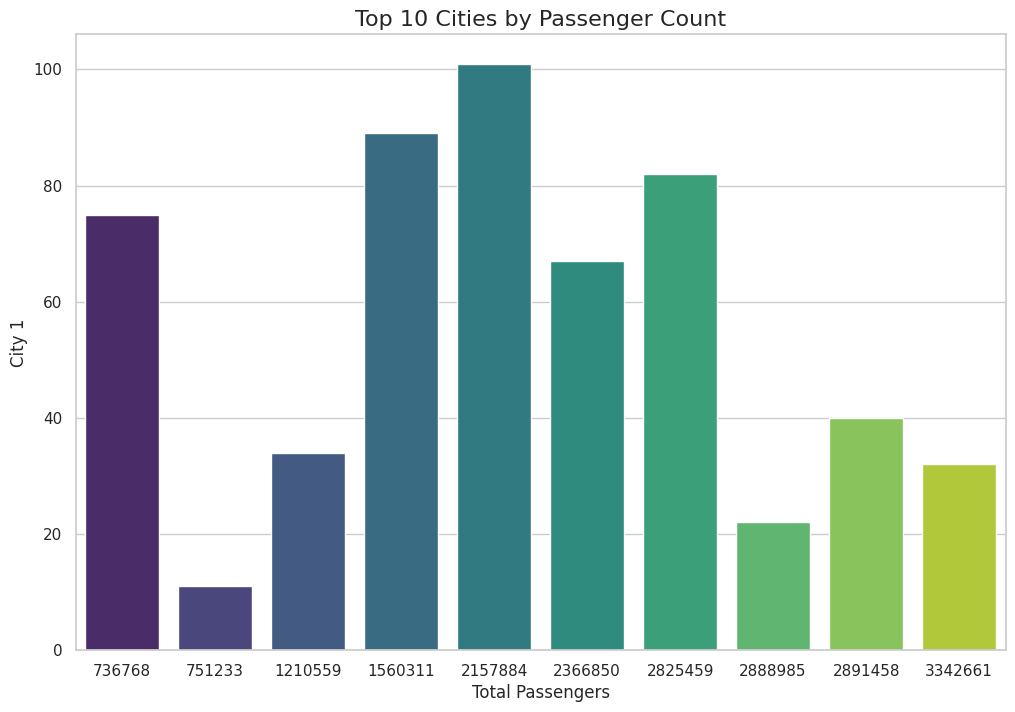

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Calculate total passengers by city and get the top 10
top_cities = df.groupby('city1')['passengers'].sum().nlargest(10).reset_index()

# Create the bar plot
sns.barplot(x='passengers', y='city1', data=top_cities, palette='viridis')

# Add titles and labels
plt.title('Top 10 Cities by Passenger Count', fontsize=16)
plt.xlabel('Total Passengers', fontsize=12)
plt.ylabel('City 1', fontsize=12)

# Show the plot
plt.show()

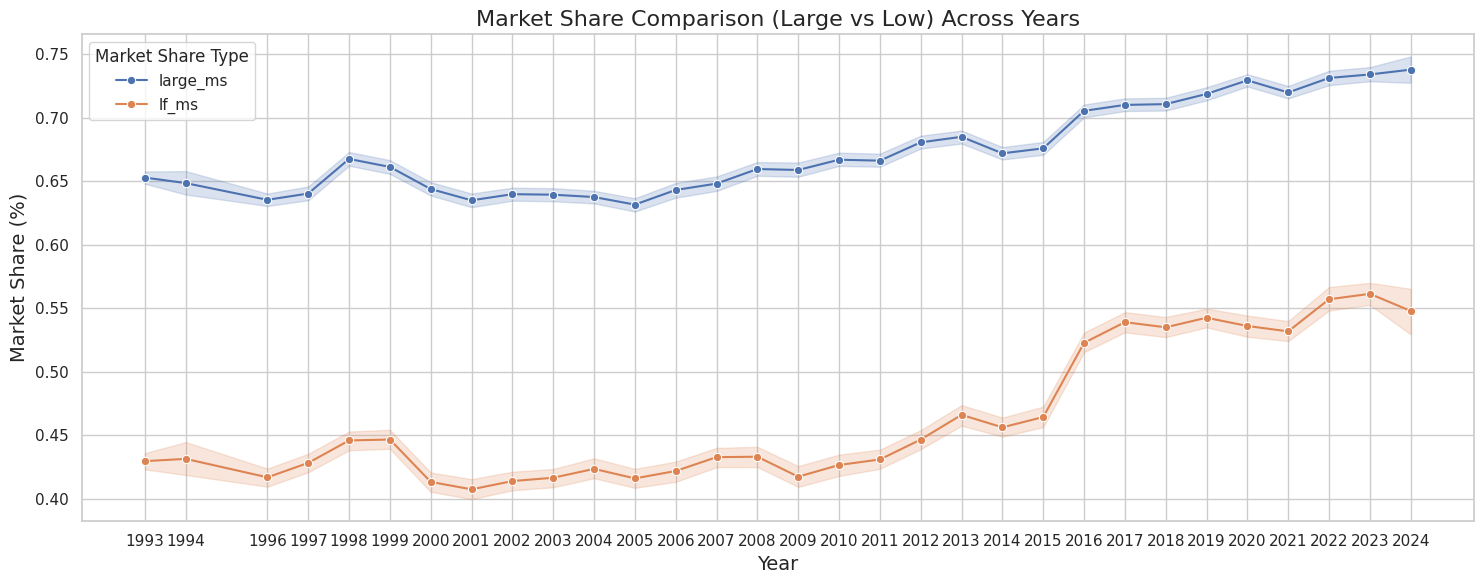

In [ ]:
# Melt the DataFrame for easier plotting
df_melted = df.melt(id_vars='Year', value_vars=['large_ms', 'lf_ms'],
                    var_name='Market Share Type', value_name='Market Share')
# Create a line plot
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_melted, x='Year', y='Market Share', hue='Market Share Type', marker='o')

# Titles and labels
plt.title('Market Share Comparison (Large vs Low) Across Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Market Share (%)', fontsize=14)
plt.grid(True)
plt.xticks(df['Year'].unique())  # Set x-ticks to years
plt.tight_layout()
plt.show()

In [ ]:
# Save the cleaned dataset
df.to_csv('cleaned_airline_data.csv', index=False)